In [31]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import time as time
import os
import csv
from scipy.signal import butter, sosfilt
from scipy.signal import hilbert
import pandas as pd
from scipy.signal import argrelextrema

get_phase_data = False
compare_contraction = True

In [32]:
from scipy.signal import savgol_filter

# Define Savitzky-Golay filter function
def savgol_filter_func(data, window_length, polyorder):
    return savgol_filter(data, window_length, polyorder)

In [33]:
# Flex foot
# ../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take1/ruthreflextrial3.csv, sep = ','
# Other flex foot (bad)
# ../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take0/ruthreflextrial1.txt, sep = '\s+'
# Two cuff
# C:/Users/tealw/Documents/PlatformIO/Projects/SmartHammer-1/src/app_v1/data_from_experiments/two_cuff/rachel 2 cuff-0001.csv
# ../../src/app_v1/data_from_experiments/two_cuff/rachel 2 cuff-0001, sep = ','
# No signal gen
# ../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/no_sig_gen/ruthtrial1.txt
# Experiment 6
#../../src/logs/exp_6_no_remove_cuff/Pico_data/exp_6_rachel_trial_1.txt
# Test waveform, Ruth local
# "C:/Users/tealw/Documents/Waveforms/test.csv"

file_name = "../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take1/ruthreflextrial1.csv"
is_csv = True

all_csv_data, active_csv_data, passive_csv_data = [], [], []
file_folder_name = file_name[:file_name.rindex("/")]
specific_file_name = file_name[file_name.rindex("/")+1:file_name.rindex(".")]

all_csv_data = pd.read_csv(file_name,skiprows=1, sep=',' if is_csv else "\s+").to_numpy()

if (compare_contraction):
    active_csv_data = pd.read_csv("../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take1/ruthactivetrial5.csv",skiprows=1, sep=',').to_numpy()
    passive_csv_data = pd.read_csv("../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take1/ruthpassivetrial5.csv",skiprows=1, sep=',').to_numpy()

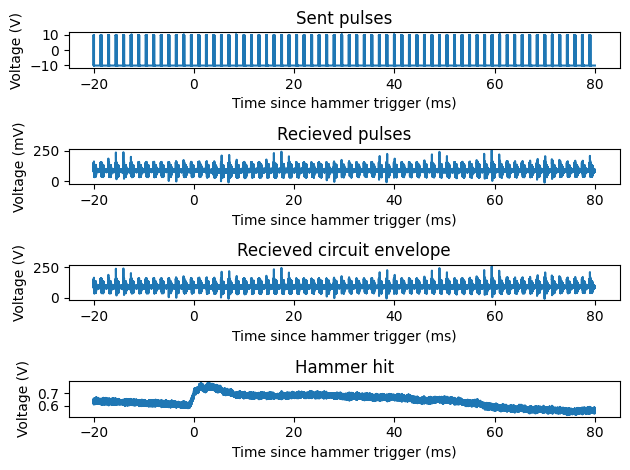

In [34]:
'''
Default column order: times, square_pulses, recieved_pulses, circuit_envelope, hammer
Flex foot take 1 order: times, calf cuff, hammer, square pulse
New test setup order (8/21/24): times, calf cuff, circuit envelope, hammer, sqaure pulse
'''
csv_times = all_csv_data[:,0]
csv_square_pulses = all_csv_data[:,3]
csv_recieved_pulses = all_csv_data[:,1]
csv_circuit_envelope =  all_csv_data[:,1]
csv_hammer = all_csv_data[:,2]

plt.figure()
plt.subplot(4,1,1)
plt.plot(csv_times,csv_square_pulses)
plt.title("Sent pulses")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(4,1,2)
plt.plot(csv_times,csv_recieved_pulses)
plt.title("Recieved pulses")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (mV)")

plt.subplot(4,1,3)
plt.plot(csv_times,csv_circuit_envelope)
plt.title("Recieved circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(4,1,4)
plt.plot(csv_times,csv_hammer)
plt.title("Hammer hit")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()

Text(0, 0.5, 'Voltage (mV)')

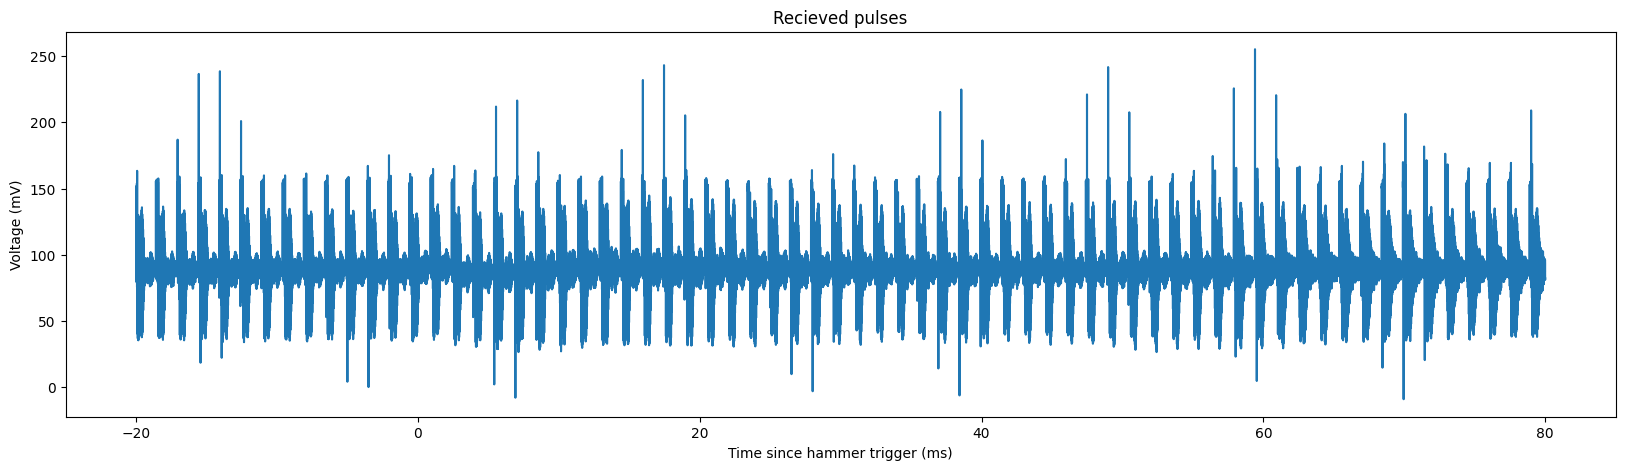

In [35]:
plt.figure(figsize=(20,5))
plt.plot(csv_times,csv_recieved_pulses)

plt.title("Recieved pulses")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (mV)")

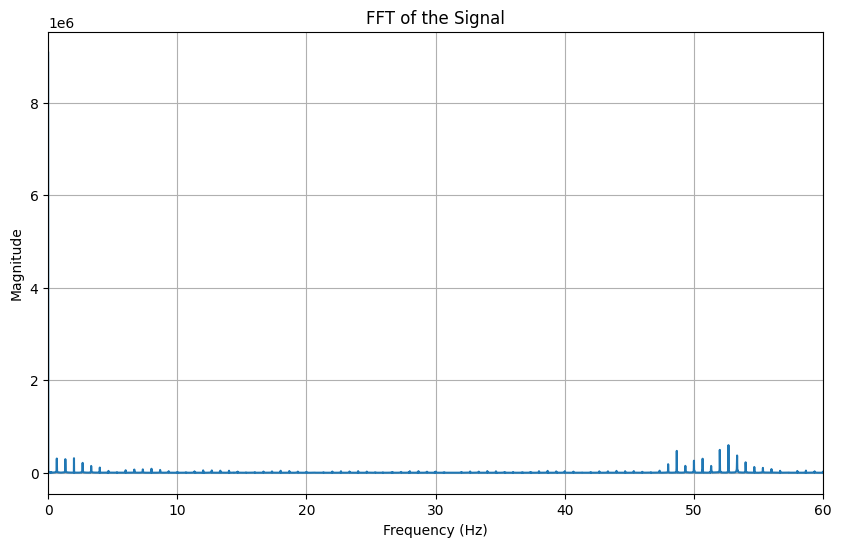

In [36]:
show_recieved_fft_plot = True

# Compute FFT
fft_values = np.fft.fft(csv_recieved_pulses)
dt = np.mean(np.diff(csv_times))
fft_frequencies = np.fft.fftfreq(len(csv_recieved_pulses), dt)

# Only take the positive frequencies (and corresponding FFT values)
positive_frequencies = fft_frequencies[:len(fft_frequencies)//2]
positive_fft_values = fft_values[:len(fft_values)//2]

peak_frequency_index = np.argmax(np.abs(positive_fft_values))
peak_frequency = positive_frequencies[peak_frequency_index]

# Plotting
if show_recieved_fft_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(positive_frequencies, np.abs(positive_fft_values))
    plt.title('FFT of the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0,60)
    plt.grid()
    plt.show()

In [37]:
from scipy.signal import find_peaks

def find_maxima_envelope(signal, sampling_rate, approx_frequency):
    """
    Find the envelope of a signal by identifying local maxima and connecting them with lines.

    Parameters:
    signal (numpy.ndarray): The input signal.
    sampling_rate (float): The sampling rate of the signal in Hz.
    approx_frequency (float): The approximate frequency of the signal in Hz.

    Returns:
    numpy.ndarray: The envelope of the input signal.
    """
    # Calculate the minimum distance between peaks in samples
    min_distance = int(sampling_rate / (approx_frequency/2))

    # Find the indices of the local maxima with the specified minimum distance
    peaks, _ = find_peaks(signal, distance=min_distance)

    # Get the values of the signal at the local maxima
    maxima = signal[peaks]

    # Interpolate between maxima to create the envelope
    envelope = np.interp(np.arange(len(signal)), peaks, maxima)

    return envelope


In [38]:
from scipy.signal import medfilt
from scipy.signal import butter, lfilter
from scipy.signal import freqs

use_raw_envelope = False
keep_raw_data = True

filtered_recieved_pulses = []
calculated_envelope = []

Filter_lowcut =40000
Filter_highcut =60000
Filter_order = 4
Sampling_frequency=1000/(all_csv_data[1,0]-all_csv_data[0,0]) # in Hz, since time is in ms
print(f"Sampling frequency: {Sampling_frequency}")
sos = butter(Filter_order, [Filter_lowcut, Filter_highcut], btype='bandpass', fs=Sampling_frequency, output='sos')

if (use_raw_envelope):
    kernel_size = 3
    window_length = 30
    polyorder = 10
    filtered_recieved_pulses = medfilt(csv_recieved_pulses, kernel_size)
    # filtered_recieved_pulses = savgol_filter(csv_recieved_pulses, window_length, polyorder)

    lowest_freq_of_recieved_sig = 20000 # needs to be much lower than 52 kHz -- this is what determines the distance between points on the envelope
    osc_sampling_freq = Sampling_frequency
    calculated_envelope = find_maxima_envelope(filtered_recieved_pulses, osc_sampling_freq, lowest_freq_of_recieved_sig)

else: 

    filtered_recieved_pulses = np.apply_along_axis(lambda x: sosfilt(sos, x), axis=0, arr = csv_recieved_pulses)

    calculated_envelope = np.abs(hilbert(filtered_recieved_pulses, axis=0))

if (keep_raw_data): filtered_recieved_pulses = csv_recieved_pulses

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y


Sampling frequency: 999999.9999987779


Text(0.5, 0, 'Time since hammer trigger (ms)')

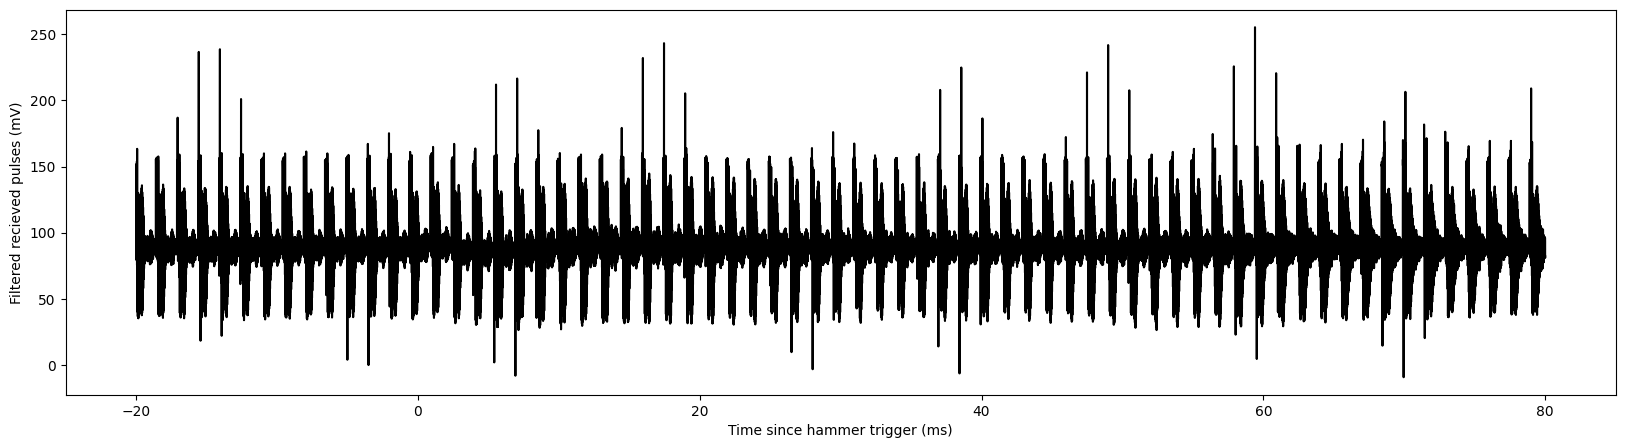

In [39]:
plt.figure(figsize=(20,5))
plt.plot(csv_times,filtered_recieved_pulses,'k')
plt.ylabel('Filtered recieved pulses (mV)')
plt.xlabel('Time since hammer trigger (ms)')

# plt.xlim((0,80))

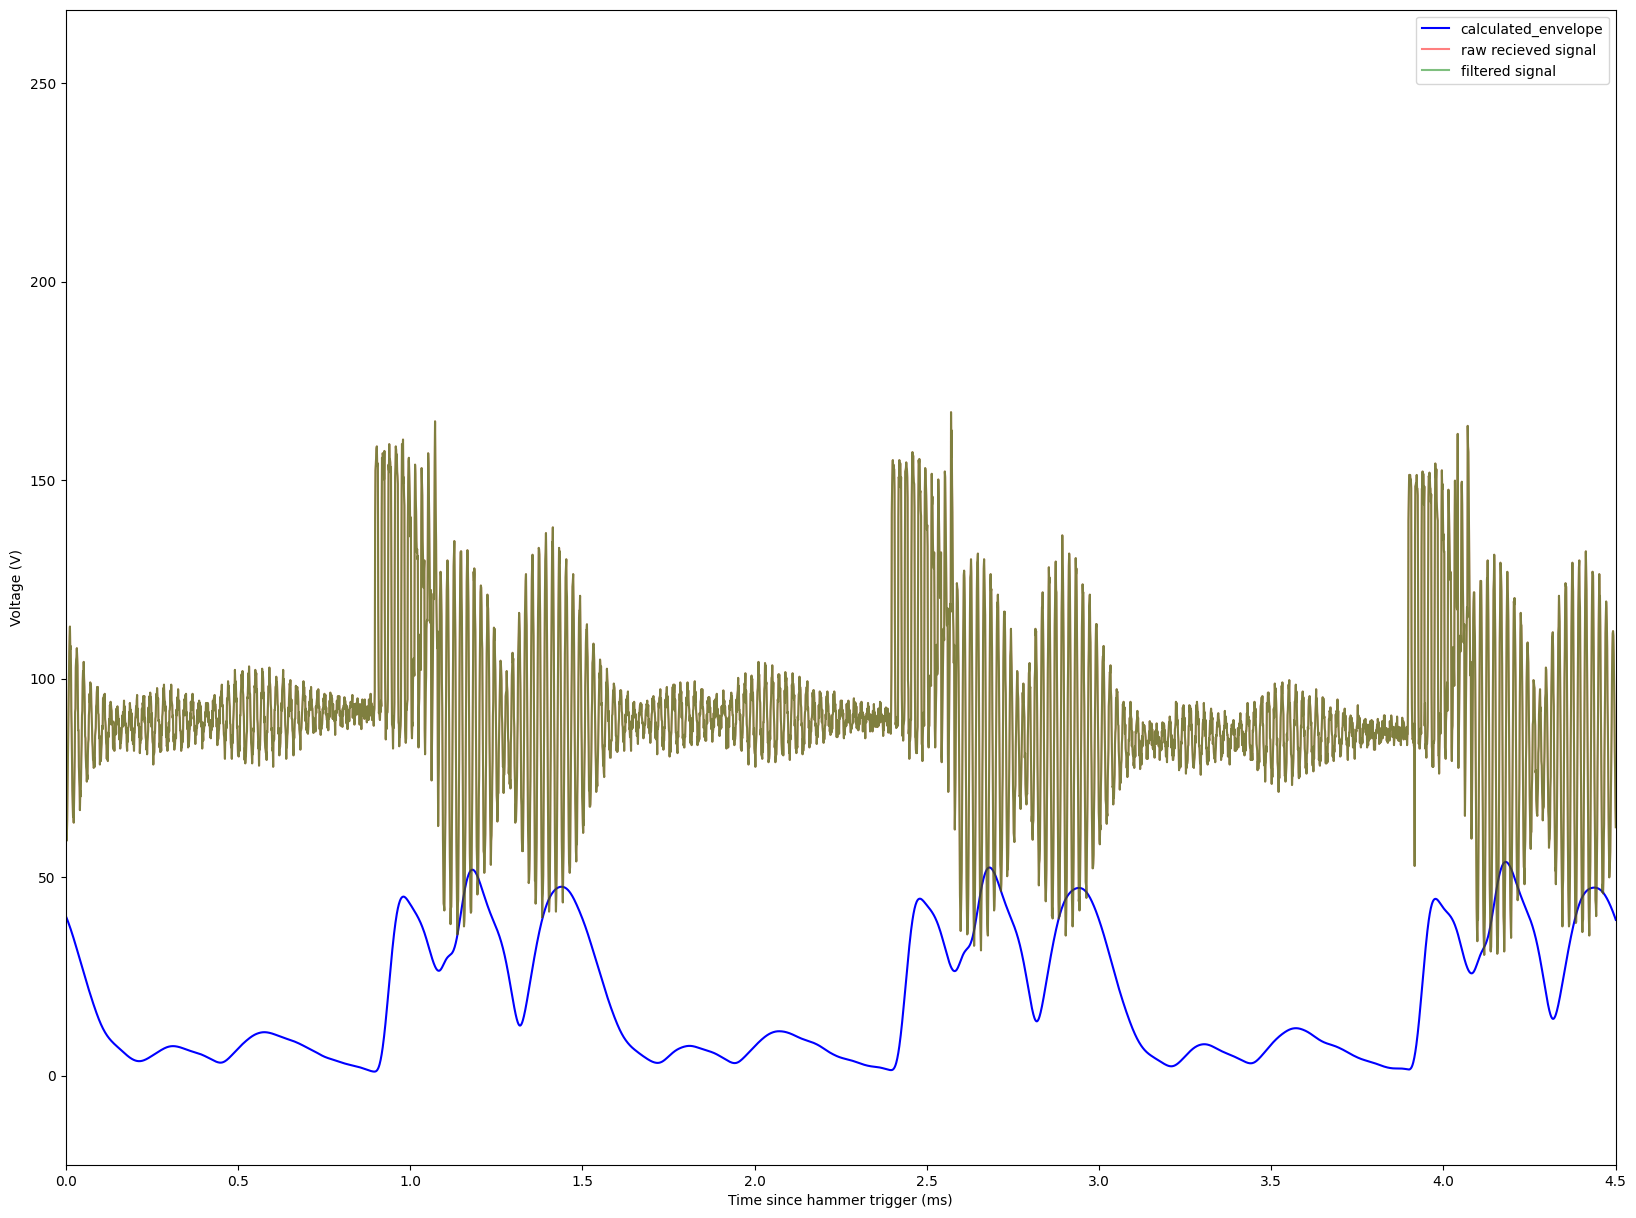

In [40]:
plt.figure(figsize=(20,15))
plt.plot(csv_times, calculated_envelope, label="calculated_envelope", color = "blue")
plt.plot(csv_times, csv_recieved_pulses, label="raw recieved signal", color = "red", alpha = 0.5)
plt.plot(csv_times, filtered_recieved_pulses,label="filtered signal", color = "green", alpha = 0.5)
plt.ylabel('Voltage (V)')
plt.xlabel('Time since hammer trigger (ms)')
plt.xlim((0,4.5))
plt.legend()

(25.0, 50.0)

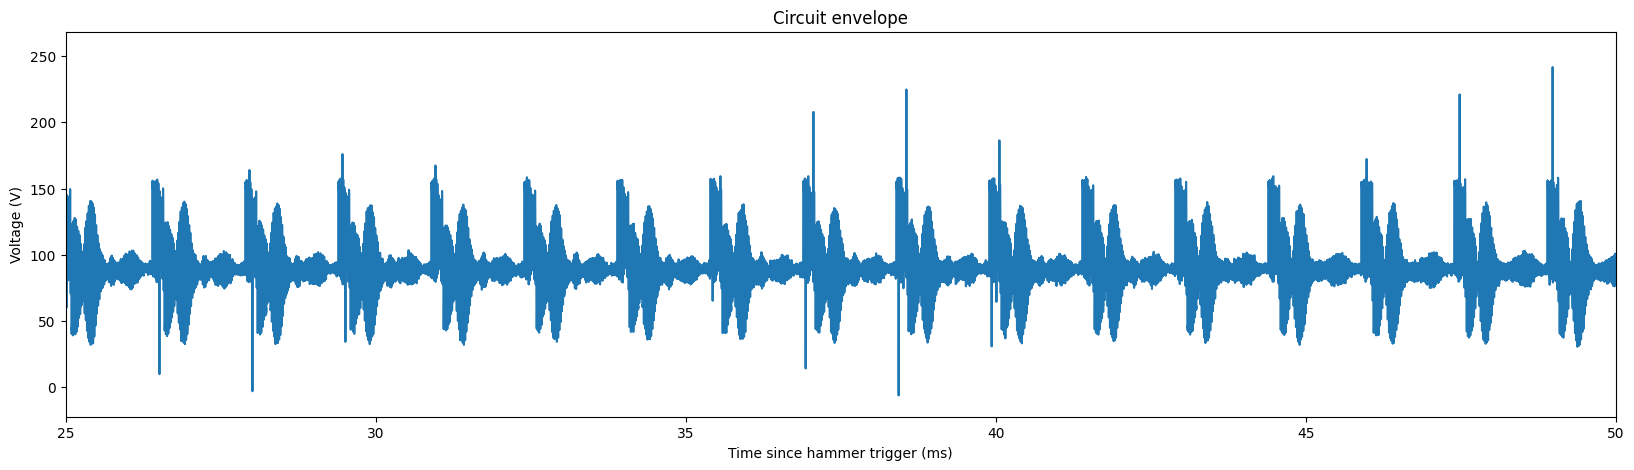

In [41]:
plt.figure(figsize=(20,5))
plt.plot(csv_times,csv_circuit_envelope)
plt.title("Circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((25,50))

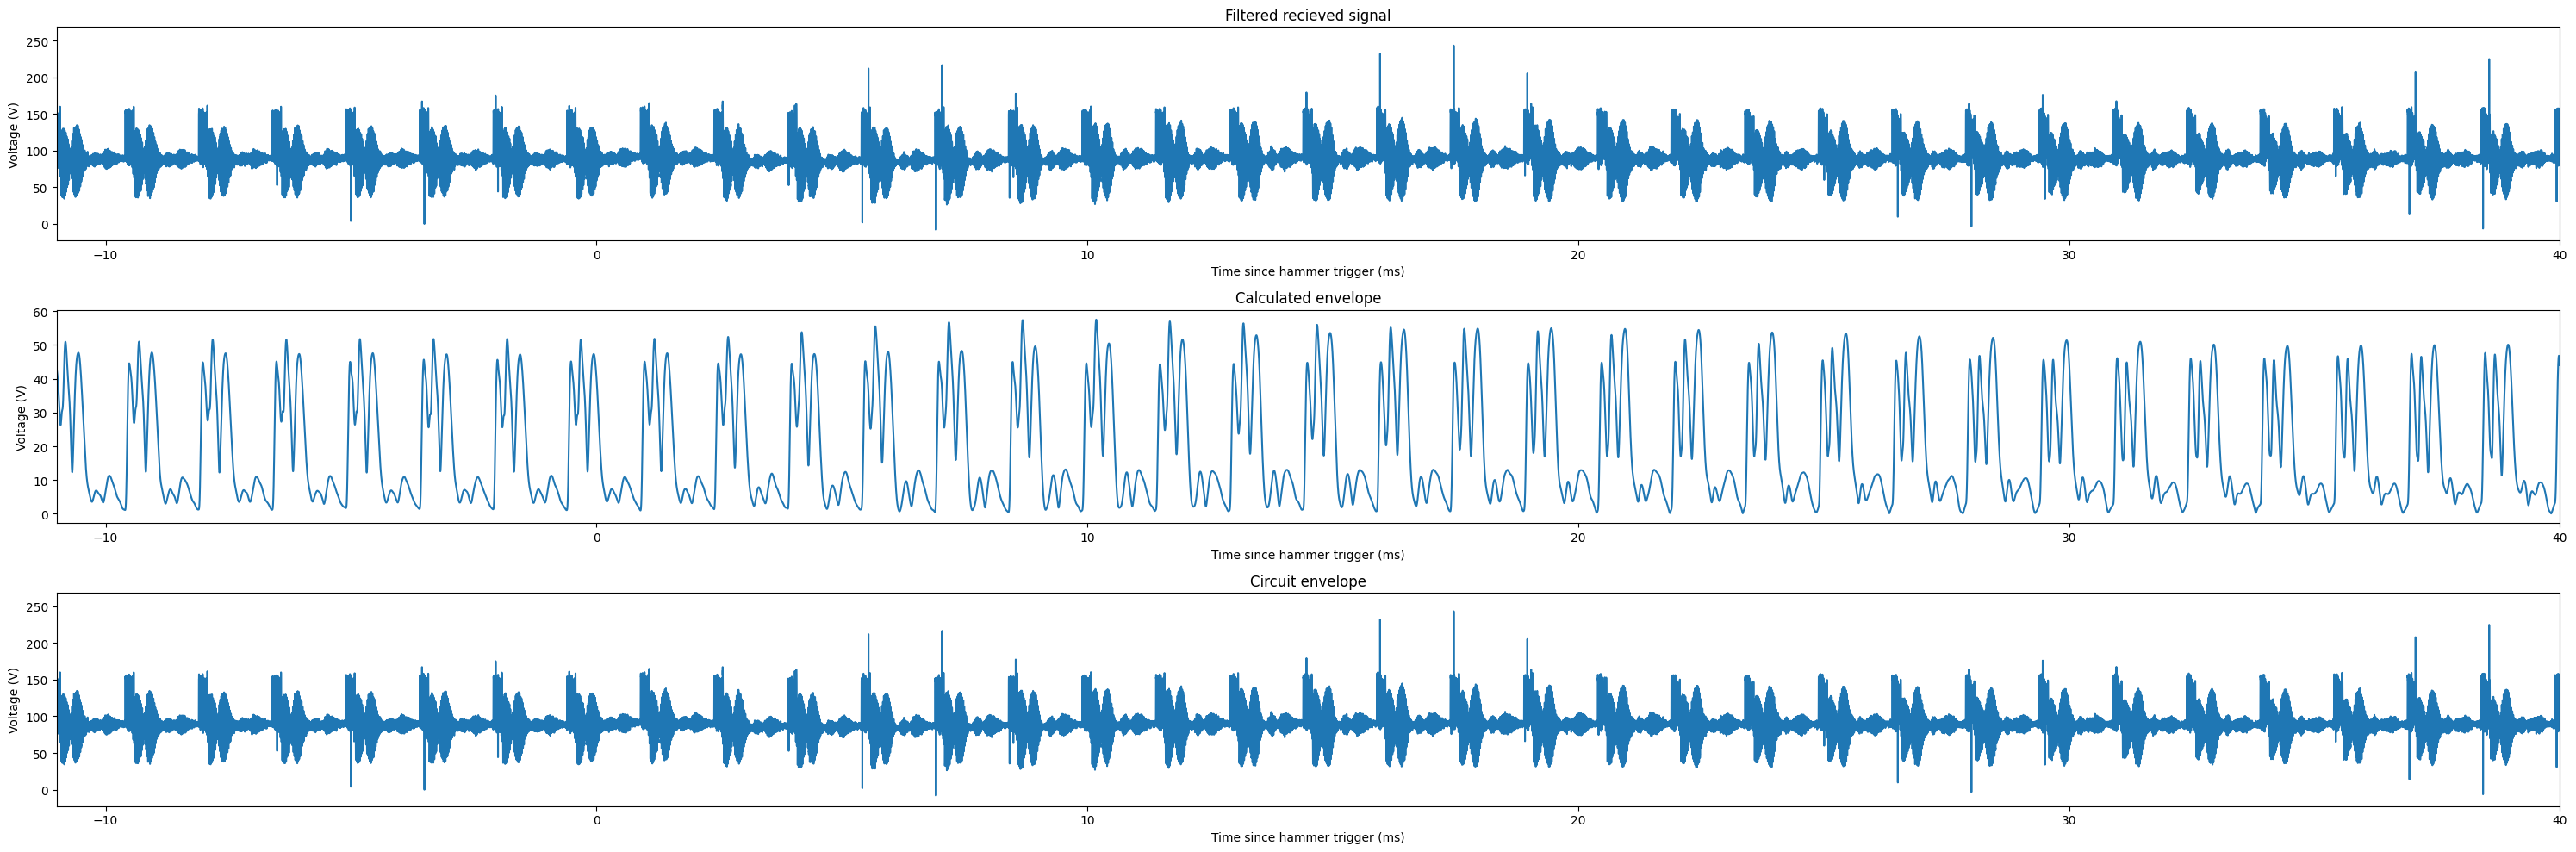

In [42]:
min_time = -11
max_time = 40

plt.figure(figsize=(30,10))
plt.subplot(3,1,1)
plt.plot(csv_times,filtered_recieved_pulses)
plt.title("Filtered recieved signal")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplot(3,1,2)
plt.plot(csv_times,calculated_envelope)
plt.title("Calculated envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplot(3,1,3)
plt.plot(csv_times,csv_circuit_envelope)
plt.title("Circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()

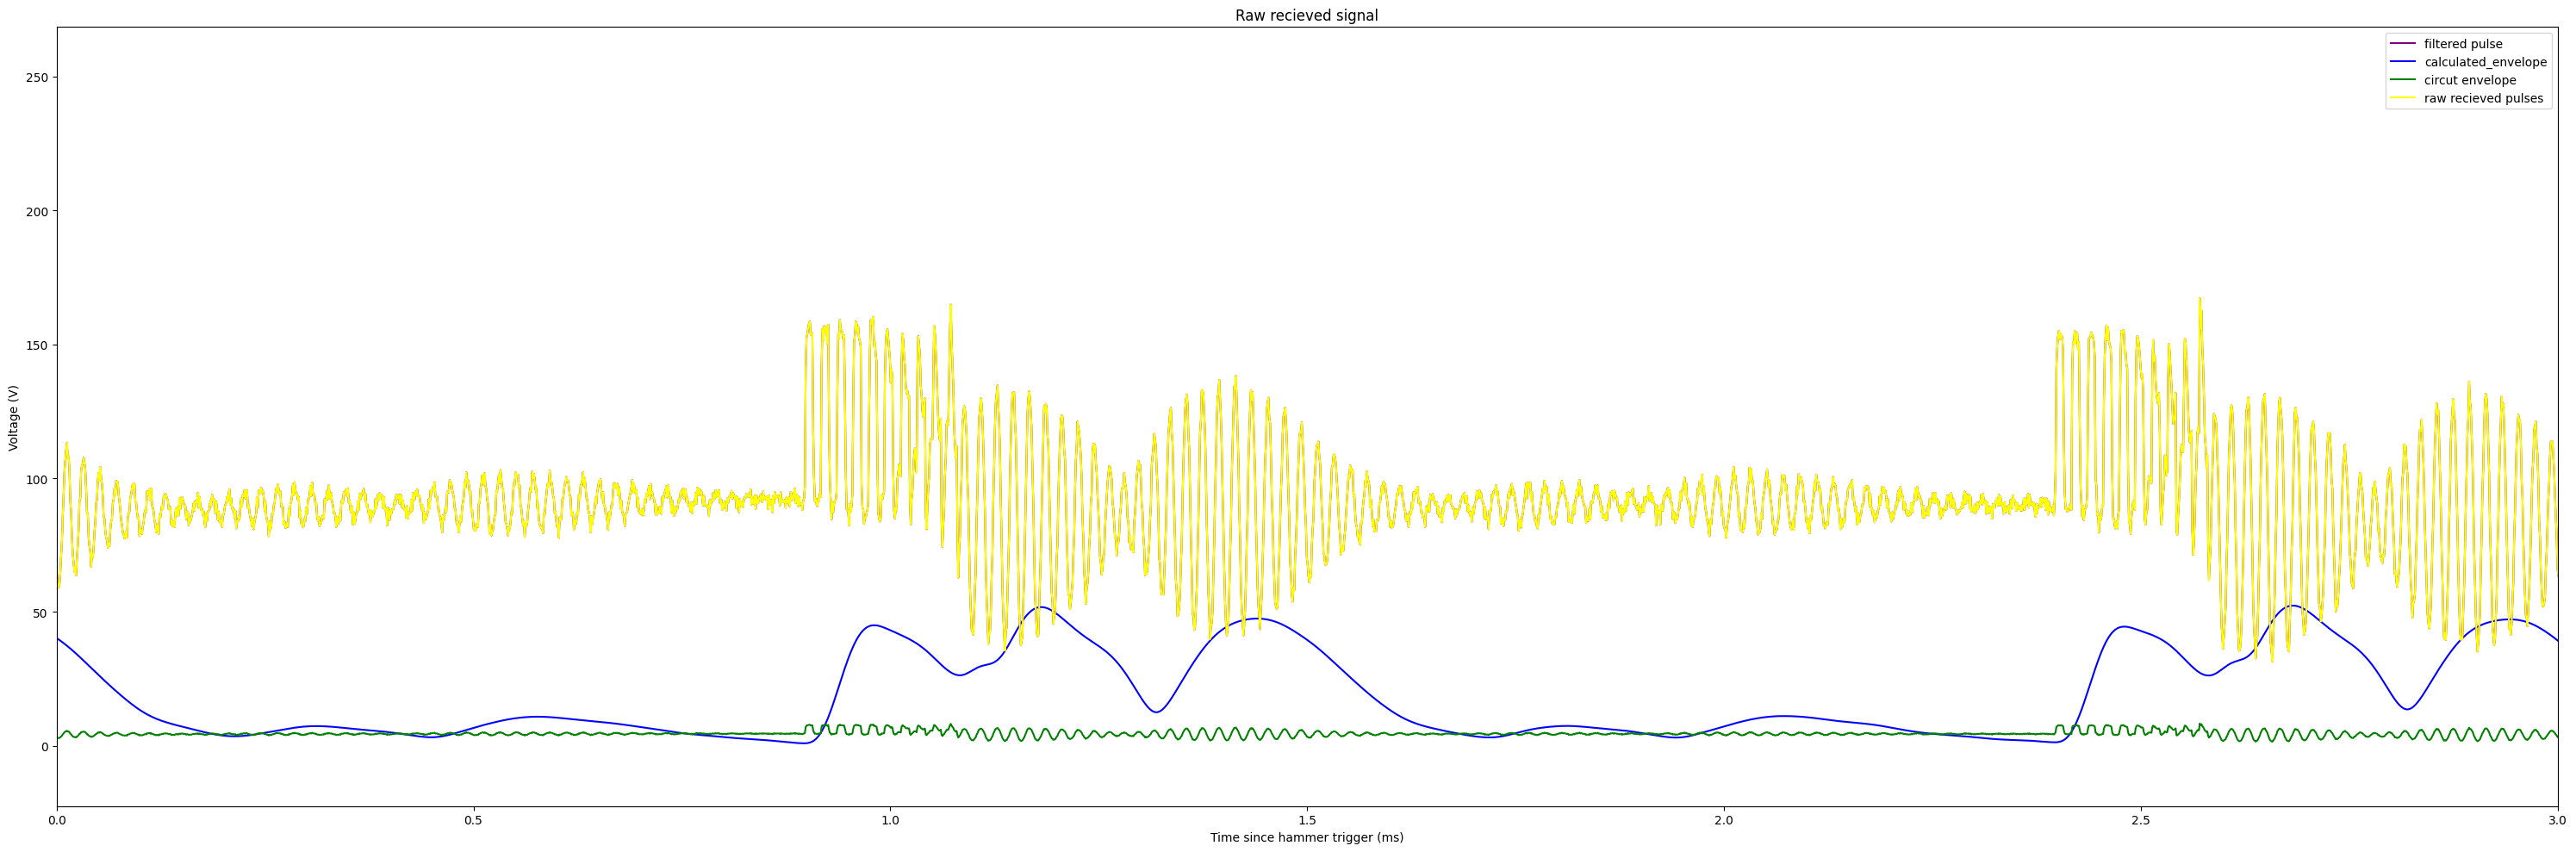

In [43]:
min_time = 0
max_time = 3

plt.figure(figsize=(30,10))
plt.plot(csv_times,filtered_recieved_pulses, label="filtered pulse", color = "purple")
plt.title("Filtered recieved signal")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.plot(csv_times,calculated_envelope, label = "calculated_envelope", color = "blue")
plt.title("Calculated envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.plot(csv_times,csv_circuit_envelope * 1/20, label = "circut envelope", color = "green")
plt.title("Circuit envelope")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.plot(csv_times,csv_recieved_pulses, label = "raw recieved pulses", color = "yellow")
plt.title("Raw recieved signal")
plt.xlabel("Time since hammer trigger (ms)")
plt.ylabel("Voltage (V)")
plt.xlim((min_time,max_time))

plt.subplots_adjust(hspace = 0.5)
plt.tight_layout()
plt.legend()

1500
NUM_PULSES: 66


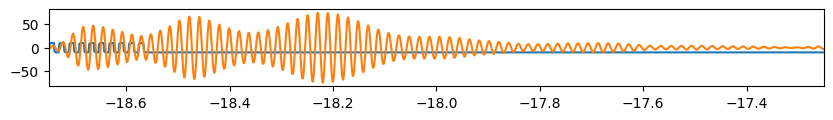

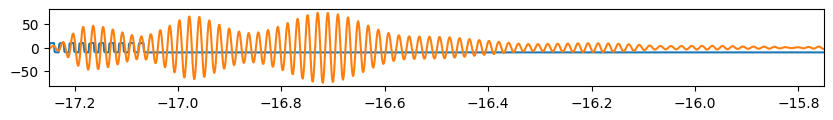

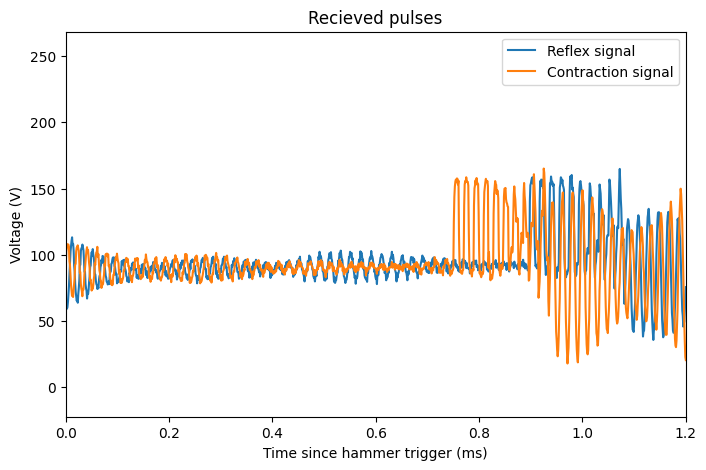

In [44]:
### CONTRACTION ONLY!!!
################################################################################### COMPARING TO CONTRACTION: GET DATA ARRAYS

active_times, active_square_pulses, active_recieved_pulses, active_circuit_envelope, active_hammer = [], [], [], [], []

if (compare_contraction):

    active_times = active_csv_data[:,0]
    active_square_pulses = active_csv_data[:,3]
    active_recieved_pulses = active_csv_data[:,1]
    active_circuit_envelope =  active_csv_data[:,1]
    active_hammer = active_csv_data[:,2]

    active_recieved_pulses_filtered = np.apply_along_axis(lambda x: sosfilt(sos, x), axis=0, arr = active_recieved_pulses)
    active_calculated_envelope = np.abs(hilbert(active_recieved_pulses_filtered, axis=0))

    ################################ New reshaping code to account for big changes in periods btw pulses
    NUM_PULSES = 0

    ### Find the start of each pulse
    active_total_start_indicies =  []

    i = 0
    r = 0
    tr = -7
    max_pulse_length_in_indicies = 0
    while i < (len(active_square_pulses) - 1):
        if (csv_square_pulses[i] < tr and active_square_pulses[i+1] >= tr):
            # print(f"{r}, {i}, {csv_square_pulses[i]}, {csv_square_pulses[i+1]}")
            active_total_start_indicies.append(i)
            if (r > 0):
                max_pulse_length_in_indicies = max(max_pulse_length_in_indicies, active_total_start_indicies[r] - active_total_start_indicies[r-1])
            r += 1
            i += 500
        i+=1
    print(max_pulse_length_in_indicies)
    NUM_PULSES = r
    print(f"NUM_PULSES: {NUM_PULSES}")

    ######## Reshaped arrays . shorter pulses padded with the last data point.
    active_calculated_envelope_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
    active_times_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
    active_recieved_pulses_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
    active_square_pulses_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))

    r = 0
    for s in range(len(active_total_start_indicies)):
        this_start = active_total_start_indicies[s]
        next_start = len(csv_times) - 1
        if (s + 1 < len(active_total_start_indicies)): next_start = active_total_start_indicies[s+1]

        for c in range(max_pulse_length_in_indicies):

            if (c + this_start < next_start):
                active_calculated_envelope_reshaped[r][c] = active_calculated_envelope[c + this_start]
                active_times_reshaped[r][c] = active_times[c + this_start]
                active_recieved_pulses_reshaped[r][c] = active_recieved_pulses_filtered[c + this_start]
                active_square_pulses_reshaped[r][c] = active_square_pulses[c + this_start]

            else:
                active_calculated_envelope_reshaped[r][c] = active_calculated_envelope[next_start - 1]
                active_times_reshaped[r][c] = active_times[next_start - 1]
                active_recieved_pulses_reshaped[r][c] = active_recieved_pulses_filtered[next_start - 1]
                active_square_pulses_reshaped[r][c] = active_square_pulses[next_start - 1]

        r += 1

    # ''' 
    # 10 pulses lasts about 200 indexes
    # Sanity check that we are slicing the pulses correctly
    for r in range(2):
        fig = plt.figure(figsize =(10, 1))
        plt.plot(active_times_reshaped[r], active_square_pulses_reshaped[r])
        plt.plot(active_times_reshaped[r], active_recieved_pulses_reshaped[r])
        plt.xlim(active_times_reshaped[r][0], active_times_reshaped[r][-1])
        plt.show()
    # '''

    plt.figure(figsize=(8,5))
    shift_active_times = 0
    plt.plot(csv_times,csv_recieved_pulses, label="Reflex signal")
    plt.plot(active_times,active_recieved_pulses, label = "Contraction signal")

    plt.title("Recieved pulses")
    plt.xlabel("Time since hammer trigger (ms)")
    plt.ylabel("Voltage (V)")
    start_time = 0
    plt.xlim(start_time, start_time + 1.2)
    plt.legend()


MAX PULSE LENGTH (in array indicies): 1500
NUM_PULSES: 67


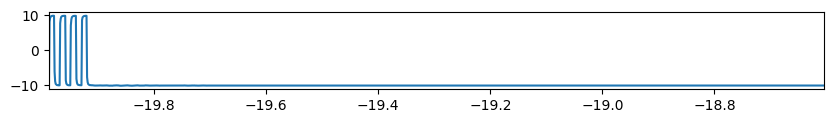

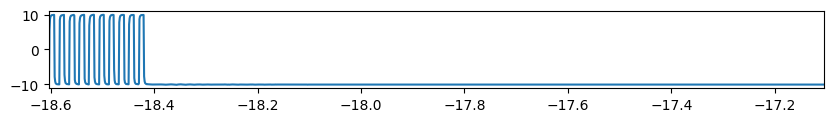

In [45]:
################################ New reshaping code to account for big changes in periods btw pulses
NUM_PULSES = 0

### Find the start of each pulse
total_start_indicies =  []
look_at_square_pulses = True

i = 0
r = 0
tr = -5
pulse_length_in_indicies = 750
max_pulse_length_in_indicies = 0
while i < (len(csv_square_pulses) - 1):
    if (look_at_square_pulses):
        if (csv_square_pulses[i] < tr and csv_square_pulses[i+1] >= tr):
            # print(f"{r}, {i}, {csv_square_pulses[i]}, {csv_square_pulses[i+1]}")
            total_start_indicies.append(i)
            if (r > 0):
                max_pulse_length_in_indicies = max(max_pulse_length_in_indicies, total_start_indicies[r] - total_start_indicies[r-1])
            r += 1
            i += 500
    elif (i % pulse_length_in_indicies == 0):
        total_start_indicies.append(i)
        if (r > 0):
            max_pulse_length_in_indicies = max(max_pulse_length_in_indicies, total_start_indicies[r] - total_start_indicies[r-1])
        r += 1
        i += 500
    i+=1
print(f"MAX PULSE LENGTH (in array indicies): {max_pulse_length_in_indicies}")
NUM_PULSES = r
print(f"NUM_PULSES: {NUM_PULSES}")

######## Reshaped arrays . shorter pulses padded with the last data point.
times_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
square_pulses_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
calculated_envelope_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
circuit_envelope_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
recieved_pulses_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))
hammer_signal_reshaped = np.zeros((NUM_PULSES, max_pulse_length_in_indicies))

r = 0
for s in range(len(total_start_indicies)):
    this_start = total_start_indicies[s]
    next_start = len(csv_times) - 1
    if (s + 1 < len(total_start_indicies)): next_start = total_start_indicies[s+1]

    for c in range(max_pulse_length_in_indicies):

        if (c + this_start < next_start):
            times_reshaped[r][c] = csv_times[c + this_start]
            square_pulses_reshaped[r][c] = csv_square_pulses[c + this_start]
            calculated_envelope_reshaped[r][c] = calculated_envelope[c + this_start]
            circuit_envelope_reshaped[r][c] = csv_circuit_envelope[c + this_start]
            recieved_pulses_reshaped[r][c] = filtered_recieved_pulses[c + this_start]
            hammer_signal_reshaped[r][c] = csv_hammer[c + this_start]

        else:
            times_reshaped[r][c] = csv_times[next_start - 1]
            square_pulses_reshaped[r][c] = csv_square_pulses[next_start - 1]
            calculated_envelope_reshaped[r][c] = calculated_envelope[next_start - 1]
            circuit_envelope_reshaped[r][c] = csv_circuit_envelope[next_start - 1]
            recieved_pulses_reshaped[r][c] = filtered_recieved_pulses[next_start - 1]
            hammer_signal_reshaped[r][c] = csv_hammer[next_start - 1]

    r += 1

start = np.zeros(NUM_PULSES)

# ''' 
# 10 pulses lasts about 200 indexes
# Sanity check that we are slicing the pulses correctly
for r in range(2):
    fig = plt.figure(figsize =(10, 1))
    plt.plot(times_reshaped[r], square_pulses_reshaped[r])
    plt.xlim(times_reshaped[r][0], times_reshaped[r][-1])
    plt.show()
# '''


limiting arrays to length 1500


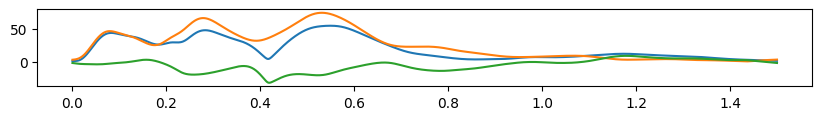

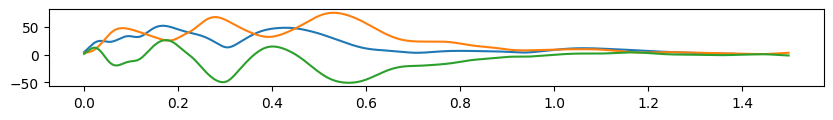

In [46]:
# 10 pulses lasts about 200 indexes
# Sanity check that we are slicing the pulses correctly
if (compare_contraction):
    pulse_nums_to_analyze = [48, 0]
    num_lim = min(len(active_calculated_envelope_reshaped[0]), len(calculated_envelope_reshaped[0]))
    print(f"limiting arrays to length {num_lim}")
    if (compare_contraction):
        for r in pulse_nums_to_analyze:
            fig = plt.figure(figsize =(10, 1))
            diff = calculated_envelope_reshaped[r][:num_lim]- active_calculated_envelope_reshaped[r][:num_lim]
            plt.plot(times_reshaped[r]-times_reshaped[r][0], calculated_envelope_reshaped[r])
            if (compare_contraction): 
                plt.plot(active_times_reshaped[r][:num_lim] - active_times_reshaped[r][:num_lim][0], active_calculated_envelope_reshaped[r][:num_lim])
                plt.plot(active_times_reshaped[r][:num_lim] - active_times_reshaped[r][:num_lim][0], diff)
            plt.show()

In [47]:
points_per_col = max_pulse_length_in_indicies - 1

square_pulses_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))
calculated_envelope_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))
circuit_envelope_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))
time_ticks = []

active_calculated_envelope_reshaped_cut = np.zeros((NUM_PULSES - 1,points_per_col))

    
for i in range(NUM_PULSES - 1):
    # For each pulse, only save certain columns (2000 data points after the start of the pulse burst)
    square_pulses_reshaped_cut[i,: ] = square_pulses_reshaped[i, start[i].astype(int) : start[i].astype(int) + points_per_col]
    calculated_envelope_reshaped_cut[i,:] = calculated_envelope_reshaped[i,start[i].astype(int):start[i].astype(int)+points_per_col]
    circuit_envelope_reshaped_cut[i,:] = circuit_envelope_reshaped[i,start[i].astype(int):start[i].astype(int)+points_per_col]

    if (compare_contraction): active_calculated_envelope_reshaped_cut[i,:] = active_calculated_envelope_reshaped[i,start[i].astype(int):start[i].astype(int)+points_per_col]

    time_ticks.append(round(times_reshaped[i, start[i].astype(int)], 2)) # Start time of each pulse


print(time_ticks)

[-19.99, -18.6, -17.1, -15.6, -14.1, -12.6, -11.1, -9.6, -8.1, -6.6, -5.1, -3.6, -2.1, -0.6, 0.9, 2.4, 3.9, 5.4, 6.9, 8.4, 9.9, 11.4, 12.9, 14.4, 15.9, 17.4, 18.9, 20.4, 21.9, 23.4, 24.9, 26.4, 27.9, 29.4, 30.9, 32.4, 33.9, 35.4, 36.9, 38.4, 39.9, 41.4, 42.9, 44.4, 45.9, 47.4, 48.9, 50.4, 51.9, 53.4, 54.9, 56.4, 57.9, 59.4, 60.9, 62.4, 63.9, 65.4, 66.9, 68.4, 69.9, 71.4, 72.9, 74.4, 75.9, 77.4]


In [48]:
if get_phase_data: 
    ############################################# Quadrature modulation time! ###########################################
    #####################################################################################################################
    #####################################################################################################################

    Filter_lowcut = 1
    Filter_highcut = 40000
    Filter_order = 4
    Sampling_frequency=1000/(all_csv_data[1,0]-all_csv_data[0,0]) # in Hz, since time is in ms
    lowpass_sin_cos_ref = butter(Filter_order, [Filter_lowcut, Filter_highcut], btype='bandpass', fs=Sampling_frequency, output='sos')


    #################################################################################### Step 1: Find dominant frequency

    show_recieved_fft_plot = False

    dt = np.mean(np.diff(csv_times))
    fs = 1 / dt  # Sampling frequency

    # Compute FFT
    fft_values = np.fft.fft(csv_recieved_pulses)
    fft_frequencies = np.fft.fftfreq(len(csv_recieved_pulses), dt)

    # Only take the positive frequencies (and corresponding FFT values)
    positive_frequencies = fft_frequencies[:len(fft_frequencies)//2]
    positive_fft_values = fft_values[:len(fft_values)//2]

    peak_frequency_index = np.argmax(np.abs(positive_fft_values))
    peak_frequency = positive_frequencies[peak_frequency_index]

    # Plotting
    if show_recieved_fft_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(positive_frequencies, np.abs(positive_fft_values))
        plt.title('FFT of the Signal')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.show()

    # convolute with boxcar, length of the 10 transmitted pulses in slow time
    # someday, if need to speed up timing: inv_fft(FFT(box) * FFT(sin_ref))

    def ruth_convolution(waveform_1):
        conv_waveform = np.zeros(len(waveform_1))
        len_boxcar = 200
        for i in range(len(waveform_1)):
            for j in range(len_boxcar):
                if (i - j < len(waveform_1) and i - j > 0): 
                    conv_waveform[i] += waveform_1[i-j] 
        return conv_waveform

    recieved_freq = peak_frequency
    #################################################################################### Step 2: Mixing 

    phase_shift = []
    phase_shift_times = []
    phase_reshaped = []
    for r in range(NUM_PULSES):

        ############################################################### Convert to baseband
        times_to_conv = times_reshaped[r]
        sin_ref_fast_time = np.sin(2*np.pi*recieved_freq*(times_to_conv - times_to_conv[0])) * recieved_pulses_reshaped[r]
        cos_ref_fast_time = np.cos(2*np.pi*recieved_freq*(times_to_conv - times_to_conv[0])) * recieved_pulses_reshaped[r]

        ################################################################ Low pass filter the sine wave
        sin_ref_fast_time =  np.apply_along_axis(lambda x: sosfilt(lowpass_sin_cos_ref, x), axis=0, arr = sin_ref_fast_time)
        cos_ref_fast_time = np.apply_along_axis(lambda x: sosfilt(lowpass_sin_cos_ref, x), axis=0, arr = cos_ref_fast_time)

        ################################################################ Convolve with boxcar (Pulse compression)
        sin_ref_fast_time = ruth_convolution(sin_ref_fast_time)
        cos_ref_fast_time = ruth_convolution(cos_ref_fast_time)

        ################################################################ Arctangent to get phase shift
        phase_shift_fast_time = np.arctan2(sin_ref_fast_time, cos_ref_fast_time)
        # plt.plot(times_to_conv, phase_shift_fast_time)
        # plt.show()

        ################################################################ Add to 1D array and 2D array
        phase_reshaped.append(phase_shift_fast_time)
        for c in range(len(phase_shift_fast_time)):
            phase_shift.append(phase_shift_fast_time[c])
            phase_shift_times.append(times_to_conv[c])

    plt.title("Phase shift versus slow time")
    plt.xlabel("Time (ms)")
    plt.ylabel("Phase shift (radians)")
    plt.plot(phase_shift_times, phase_shift)
    phase_reshaped = np.array(phase_reshaped)

    for c in range(len(phase_reshaped[0])):
        ################################################################ Filter along range line
        my_col = phase_reshaped[:,c]
        phase_reshaped[:,c] = medfilt(my_col, 9)

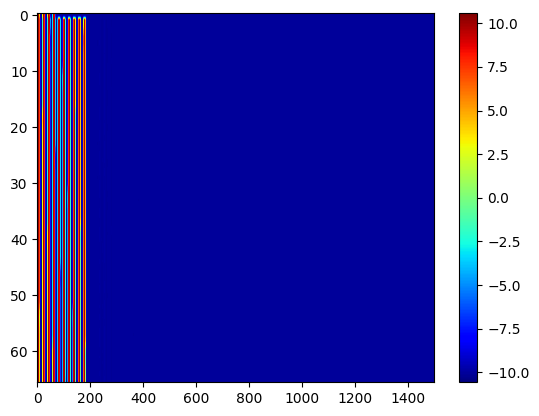

In [49]:
plt.imshow( square_pulses_reshaped_cut, aspect='auto', cmap='jet')
plt.colorbar()

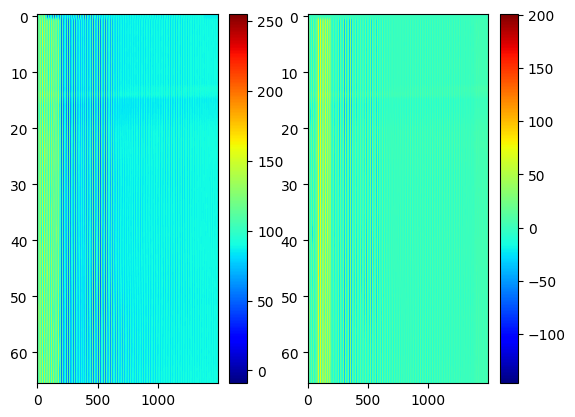

In [50]:
plt.subplot(1,2,1)
plt.imshow(circuit_envelope_reshaped_cut, aspect='auto', cmap='jet')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(circuit_envelope_reshaped_cut-circuit_envelope_reshaped_cut[0,:], aspect='auto', cmap='jet')

plt.colorbar()


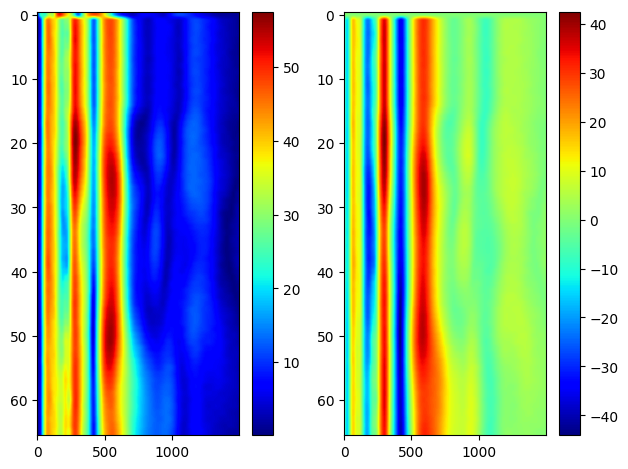

In [51]:
plt.subplot(1,2,1)
plt.imshow(calculated_envelope_reshaped_cut, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)

plt.imshow(calculated_envelope_reshaped_cut-calculated_envelope_reshaped_cut[0,:], aspect='auto', cmap='jet')
plt.colorbar()

plt.tight_layout()


In [52]:
def find_outliers_iqr(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Calculate lower and upper boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    lower_outliers = data[data < lower_bound]
    upper_outliers = data[data > upper_bound]
    
    return lower_outliers, upper_outliers, lower_bound, upper_bound

def find_outliers_std(data, threshold=3):
    # Calculate the mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Determine the lower and upper bounds
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    
    # Find outliers
    lower_outliers = data[data < lower_bound]
    upper_outliers = data[data > upper_bound]
    
    return lower_outliers, upper_outliers, lower_bound, upper_bound

In [53]:
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RectangleSelector

def plot_heat_map(input_files, stddev = 3, use_emg = False, figname = "heatmap"):
    save_place = file_folder_name + "/" + specific_file_name + "_" + str(figname) + ".png"
    
    # Retrieve the data we need for the heat map
    hammer_times = input_files[0]
    hammer_recieved = input_files[1]
    emg_recieved = input_files[2]
    cuff_times_reshaped = input_files[3]
    cuff_recieved_reshaped = input_files[4]
    time_ticks = input_files[5]
    NUM_PULSES = input_files[6]

    # Plot using GridSpec
    fig = plt.figure(figsize=(6, 8))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 0.05])

    # Hammer and EMG signal subplot
    ax1 = plt.subplot(gs[0])
    ax1.plot(hammer_times, hammer_recieved, color="blue", label="Hammer strike")
    if use_emg: ax1.plot(hammer_times, emg_recieved, color="red", label="EMG signal")
    ax1.set_xlim(time_ticks[0], time_ticks[-1])
    if use_emg: ax1.set_title('Hammer and EMG voltage vs time') 
    else: ax1.set_title("Hammer voltage vs time")
    ax1.set_ylabel('Voltage (V)')
    ax1.set_xlabel('Time (ms)')
    ax1.legend()

    # Cuff signal subplot
    ax2 = plt.subplot(gs[1])
    cuff_vals_for_heatmap = np.asarray(cuff_recieved_reshaped) - np.asarray(cuff_recieved_reshaped)[0, :]
    lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(cuff_vals_for_heatmap, stddev)
    im = ax2.imshow(np.transpose(cuff_vals_for_heatmap), aspect='auto', cmap='jet', vmin=lower_lim_imshow, vmax=upper_lim_imshow)
    ax2.set_title(figname+':\nPulse height vs time normalize to start of pulse, all pulses overlayed')
    ax2.set_ylabel('Array index within pulse')
    ax2.set_xlabel('Start time of pulse (ms)')
    time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES / len(time_ticks))
    ax2.set_xticks(ticks=time_tick_positions[0::5])
    ax2.set_xticklabels(labels=time_ticks[0::5])
    ax2.tick_params(axis='x', rotation=90)

    # Colorbar subplot
    cbar_ax = plt.subplot(gs[2])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    ############################################################# Stuff to select area and find max point
    max_amplitude_text = ax2.text(0, 0, '', color='white', fontsize=12, ha='center')
    max_point_marker, = ax2.plot([], [], 'ro')

    def on_select(eclick, erelease):
        # Get the coordinates of the rectangle
        x1, y1 = int(eclick.xdata), int(eclick.ydata)
        x2, y2 = int(erelease.xdata), int(erelease.ydata)
        
        # Define the rectangle area
        x_min, x_max = sorted([x1, x2])
        y_min, y_max = sorted([y1, y2])
        data = np.transpose(cuff_vals_for_heatmap)
        absdata = np.abs(np.transpose(cuff_vals_for_heatmap))

        # Get the subarray of the selected area
        selected_area = absdata[y_min:y_max+1, x_min:x_max+1]
        
        # Find the indices of the maximum value within the selected area
        max_idx = np.unravel_index(np.argmax(selected_area), selected_area.shape)
        max_y, max_x = max_idx[0] + y_min, max_idx[1] + x_min
        max_value = data[max_y, max_x]
        time_of_max = np.transpose(cuff_times_reshaped)[max_y, max_x]
        
        # Update the annotation and marker
        max_amplitude_text.set_position((max_x, max_y))
        max_amplitude_text.set_text(f'{time_of_max}, {max_value:.2f}')
        max_point_marker.set_data(max_x, max_y)
        
        # Print the row and column index of the maximum point
        print(f'Manual select found: Maximum muscle contraction found at {time_of_max} ms after hammer hit')
        
        # Redraw the figure to update the annotation and marker
        fig.canvas.draw_idle()
        plt.savefig(save_place)

    # Create the RectangleSelector
    rect_selector = RectangleSelector(ax2, on_select, useblit=True,
                                        button=[1], minspanx=5, minspany=5, spancoords='pixels',
                                        interactive=True)


    # Save the figure before showing it
    plt.subplots_adjust(hspace=1)
    plt.savefig(save_place)
    plt.show()
    
    # Return time of reflex
    min_reflex_time = 28 # in ms
    max_reflex_time = 50 # in ms
    min_reflex_index_within_pulse = 30
    reflex_time = 0
    max_amplitude_heat_map = 0
    for r in range(NUM_PULSES):
        for c in range(min_reflex_index_within_pulse, len(cuff_recieved_reshaped[r])):
            amplitude_diff = cuff_recieved_reshaped[r][c] - cuff_recieved_reshaped[0][c]
            if (cuff_times_reshaped[r][c] < min_reflex_time or cuff_times_reshaped[r][c] > max_reflex_time): continue
            if np.abs(amplitude_diff) > max_amplitude_heat_map and amplitude_diff > lower_lim_imshow and amplitude_diff < upper_lim_imshow:
                max_amplitude_heat_map = np.abs(amplitude_diff)
                reflex_time = cuff_times_reshaped[r][c]
    print(f"Auto-detect found: Maximum muscle contraction found at {reflex_time} ms after hammer hit.")

    plt.close(fig)
    print("Saving to: "+save_place)



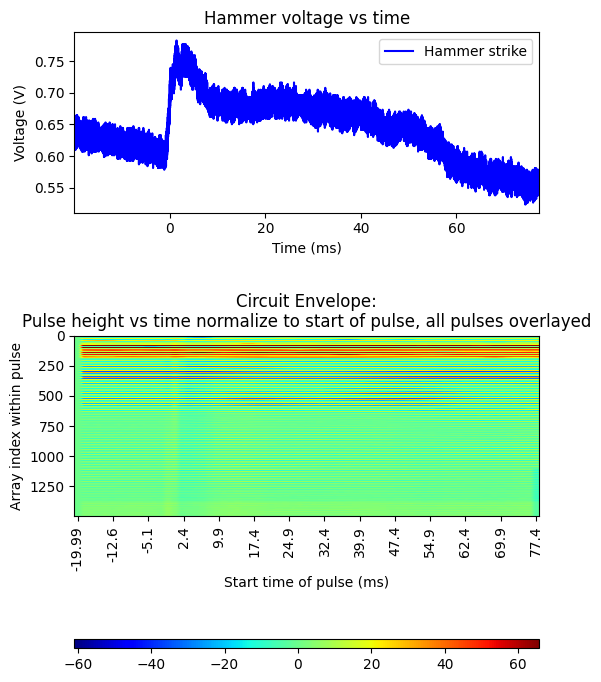

Auto-detect found: Maximum muscle contraction found at 32.5224465 ms after hammer hit.
Saving to: ../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take1/ruthreflextrial1_Circuit Envelope.png


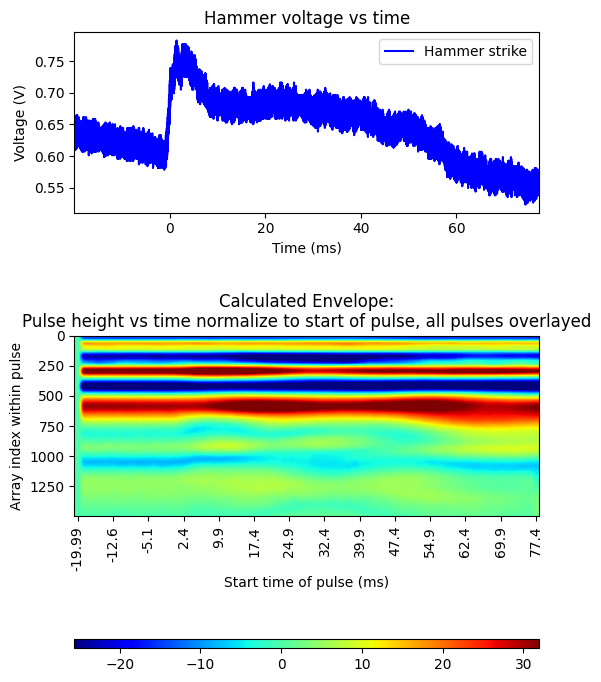

Auto-detect found: Maximum muscle contraction found at 36.00344649 ms after hammer hit.
Saving to: ../../src/app_v1/data_from_experiments/flex_foot/ruth_flex_foot_pico/take1/ruthreflextrial1_Calculated Envelope.png


In [54]:
circuit_env_data = [csv_times, csv_hammer, [], times_reshaped, circuit_envelope_reshaped, time_ticks, NUM_PULSES]
calc_env_data = [csv_times, csv_hammer, [], times_reshaped, calculated_envelope_reshaped, time_ticks, NUM_PULSES]
phase_data = [csv_times, csv_hammer, [], times_reshaped, phase_reshaped, time_ticks, NUM_PULSES] if get_phase_data else []
plot_heat_map(circuit_env_data, figname="Circuit Envelope")
plot_heat_map(calc_env_data, figname="Calculated Envelope", stddev=2)

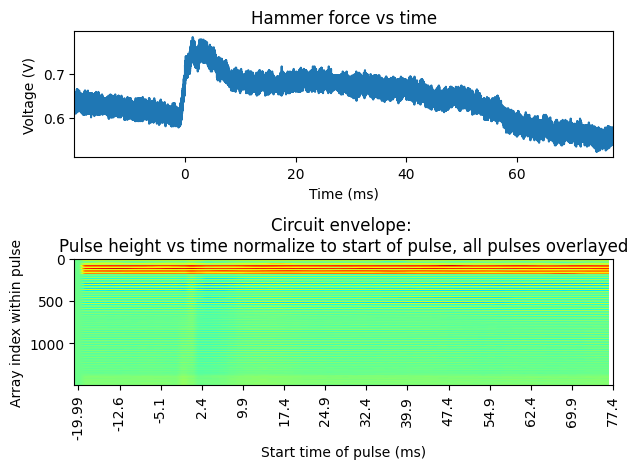

In [55]:
plt.subplot(2,1,1)
plt.plot(csv_times,csv_hammer)
these_ticks = time_ticks[0::5]
plt.xlim(these_ticks[0], these_ticks[-1])
plt.title('Hammer force vs time')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (ms)')

plt.subplot(2,1,2)

new_arr = circuit_envelope_reshaped_cut-circuit_envelope_reshaped_cut[0,:]
#new_arr[0,0] = np.max(np.abs(new_arr))
#new_arr[0,1] = -1 * np.max(np.abs(new_arr))

# Set limits for imshow and plot
lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(new_arr)
plt.imshow(np.transpose(new_arr), aspect='auto', cmap='jet', vmin = lower_lim_imshow, vmax = upper_lim_imshow)

time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES/len(time_ticks))
plt.xticks(ticks = time_tick_positions[0::5], labels = time_ticks[0::5])
plt.xticks(rotation=90)
plt.title('Circuit envelope: \nPulse height vs time normalize to start of pulse, all pulses overlayed')
plt.ylabel('Array index within pulse')
plt.xlabel('Start time of pulse (ms)')

plt.tight_layout()

In [56]:
if (get_phase_data):

    plt.subplot(2,1,1)
    plt.plot(csv_times,csv_hammer)
    plt.xlim(time_ticks[0], time_ticks[-1])
    plt.title('Hammer force vs time')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (ms)')

    plt.subplot(2,1,2)

    new_arr = phase_reshaped-phase_reshaped[0,:]
    #new_arr[0,0] = np.max(np.abs(new_arr))
    #new_arr[0,1] = -1 * np.max(np.abs(new_arr))

    lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(new_arr, 3)
    plt.imshow(np.transpose(new_arr), aspect='auto', cmap='jet', vmin = lower_lim_imshow, vmax = upper_lim_imshow)

    plt.title('Phase shift: \nPulse height vs time normalize to start of pulse, all pulses overlayed')
    plt.ylabel('Array index within pulse')
    plt.xlabel('Start time of pulse (ms)')

    time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES/len(time_ticks))
    plt.xticks(ticks = time_tick_positions[0::5], labels = time_ticks[0::5])
    plt.xticks(rotation=90)

    plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()

In [57]:
if (get_phase_data):
    c_to_plot = [100, 300, 500, 700, 900]
    for c in c_to_plot:
        plt.plot(times_reshaped[:,c], circuit_envelope_reshaped[:,c] - circuit_envelope_reshaped[:,c][0], label = "c = "+str(c))
    plt.xlabel("Slow time (ms)")
    plt.ylabel("Phase shift (radians)")
    plt.title(f"Phase shift versus time for index within pulse")
    plt.legend()

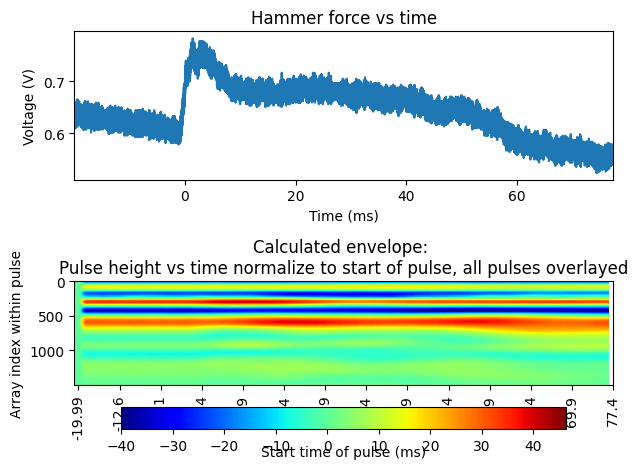

In [58]:
plt.subplot(2,1,1)
plt.plot(csv_times,csv_hammer)
plt.xlim(time_ticks[0], time_ticks[-1])
plt.title('Hammer force vs time')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (ms)')

plt.subplot(2,1,2)

num_lim = len(calculated_envelope_reshaped_cut[0])
if (compare_contraction):
    num_lim = min(len(calculated_envelope_reshaped_cut[0]), len(active_calculated_envelope_reshaped_cut[0]))


new_arr = calculated_envelope_reshaped_cut[:, 0:num_lim]
new_arr = new_arr-new_arr[0,:]

new_arr_2 = []
if (compare_contraction):
    new_arr_2 = calculated_envelope_reshaped_cut[:, 0:num_lim] - active_calculated_envelope_reshaped_cut[:, 0:num_lim]
    new_arr_2 = new_arr_2 - new_arr_2[0,:]

# new_arr = new_arr_2
# new_arr = new_arr - new_arr_2

lower_outliers, upper_outliers, lower_lim_imshow, upper_lim_imshow = find_outliers_std(new_arr, 3)
plt.imshow(np.transpose(new_arr), aspect='auto', cmap='jet', vmin=lower_lim_imshow, vmax=upper_lim_imshow)

plt.title('Calculated envelope: \nPulse height vs time normalize to start of pulse, all pulses overlayed')
plt.ylabel('Array index within pulse')
plt.xlabel('Start time of pulse (ms)')

time_tick_positions = np.arange(0, NUM_PULSES, NUM_PULSES/len(time_ticks))
plt.xticks(ticks = time_tick_positions[0::5], labels = time_ticks[0::5])
plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.5)
plt.colorbar(orientation='horizontal')
plt.tight_layout()

IndexError: index 66 is out of bounds for axis 0 with size 66

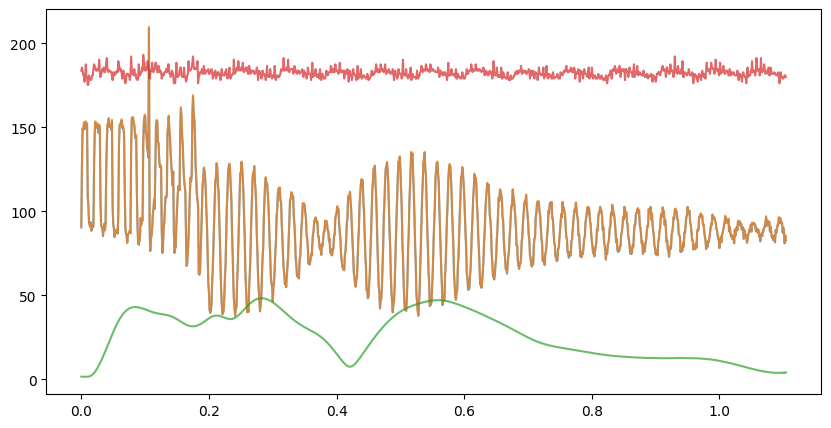

In [59]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
save_as_mp4 = True # Saves as GIF when this is false. You need ffmeg installed to save as mp4.
plot_circuit_envelope = True
plot_calculated_envelope = True
plot_hammer = True
min_y_axis = min(filtered_recieved_pulses)-1
max_y_axis = max(filtered_recieved_pulses)+1
scale_circuit_envelope = max_y_axis*1.0/max(csv_circuit_envelope)
scale_hammer = max_y_axis*1.0/max(csv_hammer)

shift_active_up =  np.average(filtered_recieved_pulses) - np.average(active_recieved_pulses_filtered) if compare_contraction else 0
shift_calc_env_up = 0 #np.average(filtered_recieved_pulses) - np.average(calculated_envelope)

def update(frame):
    plt.cla()  # Clear the current axes
    plt.plot(times_reshaped[frame] - times_reshaped[frame][0], recieved_pulses_reshaped[frame], label=f'Filtered recieved signal', alpha=0.7)
    if (plot_circuit_envelope): 
        plt.plot(times_reshaped[frame] - times_reshaped[frame][0], circuit_envelope_reshaped[frame]*scale_circuit_envelope, label=f'Circuit envelope', alpha=0.7)
    if (plot_calculated_envelope):
        plt.plot(times_reshaped[frame] - times_reshaped[frame][0], calculated_envelope_reshaped[frame]+shift_calc_env_up, label=f'Calculated envelope. shifted {shift_calc_env_up:.2f} mV up', alpha=0.7)
    if (plot_hammer):
        plt.plot(times_reshaped[frame] - times_reshaped[frame][0], hammer_signal_reshaped[frame]*scale_hammer, label=f'Hammer (scaled {scale_hammer:.2f})', alpha=0.7)
    if (compare_contraction):
        plt.plot(active_times_reshaped[frame] - active_times_reshaped[frame][0], active_recieved_pulses_reshaped[frame]+shift_active_up, label=f'Active contraction pulse, shifted {shift_active_up:.2f} mV up', alpha=0.3)
    plt.legend(loc='upper right')
    plt.xlim(0, times_reshaped[0][-1] - times_reshaped[0][0])
    plt.ylim(min_y_axis, max_y_axis)
    plt.title(f'Pulse {frame}, starts at {times_reshaped[frame][0]} ms since hammer hit')
    plt.xlabel('Time (ms) within pulse')
    plt.ylabel('Amplitude (mV)')

fig, ax = plt.subplots(figsize=(10, 5))
ani = FuncAnimation(fig, update, frames=NUM_PULSES, repeat=False)

# Save as GIF
extension = ".mp4" if save_as_mp4 else ".gif"
save_place = file_folder_name + "/" + specific_file_name + '_pulse_animation' + extension
writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800) if save_as_mp4 else PillowWriter(fps=10)
ani.save(save_place, writer)
print(f"Saved at: {save_place}")
plt.show()